# Rotinas para a detecção das não-bijetividades

In [1]:
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.insert(0,'..')
import lib.tf_levenberg_marquardt.levenberg_marquardt as lm
import tensorflow as tf
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from tensorflow import keras
from keras import layers
from itertools import product
from time import time

In [2]:
def load_csv2numpy(p):
    return np.loadtxt(p, delimiter=',', dtype=np.float32, skiprows=1)

In [3]:
def z2n(n):
    return n if n<0 else None

In [4]:
def prep_data(x, M):
    a0 = np.abs(x)
    end = z2n(-M-1)
    abs = [a0[:end],]
    for m in range(M):
        end = z2n(-M+m)
        abs.append(a0[m+1:end])
    abs = np.array(abs).T

    p0 = np.angle(x)
    end = z2n(-M-1)
    phase = [p0[:end],]
    for m in range(M):
        end = z2n(-M+m)
        phase.append(p0[m+1:end])
    phase = np.array(phase).T

    delta = []
    for m in range(1,M+1):
        delta.append(phase[:,m]-phase[:,m-1])
    delta = np.array(delta).T
    
    d_cos = np.cos(delta)
    d_sin = np.sin(delta)
    return abs, d_cos, d_sin

In [5]:
def recuperar_data(s, x):
    y = s*np.exp(1j*np.angle(x))
    return y

In [6]:
def gerar_s(y, x, M=0):
    s = y[M:-1]*np.exp(-1j*np.angle(x[M:-1]))
    return s.real, s.imag

In [7]:
def normalize_data(x):
    return (x)/np.std(x)

In [8]:
def find_best_M_HL(x, y, M_min=0, M_max=10, HL_min=1, HL_max=10):
    best_model = None
    best_nmse = np.inf
    metaparams = product(range(M_min,M_max+1), range(HL_min,HL_max+1))
    for M, HL in metaparams:
        start = time()
    
        a,dc,ds = prep_data(x, M)
        inputs = np.concatenate([a,dc,ds], axis=1)
        s_real, s_imag = gerar_s(y,x,M)
    
        size_input = 1+3*(M)

        inputs_real = keras.Input(shape=(size_input,))
        hidden_real = layers.Dense(HL, activation='tanh')(inputs_real)
        output_real = layers.Dense(1, activation='linear')(hidden_real)
        model_real = keras.Model(inputs=inputs_real, outputs=output_real, name='Parte_Real')
        model_real = lm.ModelWrapper(model_real)
        # model_real.summary()

        inputs_imag = keras.Input(shape=(size_input,))
        hidden_imag = layers.Dense(HL, activation='tanh')(inputs_imag)
        output_imag = layers.Dense(1, activation='linear')(hidden_imag)
        model_imag = keras.Model(inputs=inputs_imag, outputs=output_imag, name='Parte_Imaginaria')
        model_imag = lm.ModelWrapper(model_imag)
        # model_imag.summary()

        model_real.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
            loss=lm.MeanSquaredError(),
            metrics=['accuracy','mse'])

        model_imag.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
            loss=lm.MeanSquaredError(),
            metrics=['accuracy','mse'])

        history = model_real.fit(inputs, s_real, epochs=100, batch_size=2048, verbose=0)
        history = model_imag.fit(inputs, s_imag, epochs=100, batch_size=2048, verbose=0)
        s_hat_real = model_real.predict(inputs, verbose=0).reshape(-1,)
        s_hat_imag = model_imag.predict(inputs, verbose=0).reshape(-1,)

        s_hat = s_hat_real + 1j*s_hat_imag
        y_hat = recuperar_data(s_hat, x[M:-1])
        # nmse
        nmse = 10*np.log10(
            np.sum(np.abs(y[M:-1]-y_hat)**2)/
            np.sum(np.abs(y[M:-1])**2)
            )
        end = time()
        if nmse < best_nmse:
            best_nmse = nmse
            best_model = model_real, model_imag
            best_M = M
            print('*** BEST ***')
            print(f'Shape:{inputs.shape[1]} M:{M} HL:{HL} nmse:{nmse} time:{end-start}')
        if best_nmse < -45.0:
            break
    return best_model, best_M

In [9]:
def validation(model, x, y, M):
    a,dc,ds = prep_data(x, M)
    inputs = np.concatenate([a,dc,ds], axis=1)
    
    s_hat_real = model[0].predict(inputs, verbose=0).reshape(-1,)
    s_hat_imag = model[1].predict(inputs, verbose=0).reshape(-1,)

    s_hat = s_hat_real + 1j*s_hat_imag
    y_hat = recuperar_data(s_hat, x[M:-1])
    # nmse
    nmse = 10*np.log10(
        np.sum(np.abs(y[M:-1]-y_hat)**2)/
        np.sum(np.abs(y[M:-1])**2)
        )
    print(f'Validação - nmse:{nmse}')
    model[0].summary()
    model[1].summary()
    return nmse

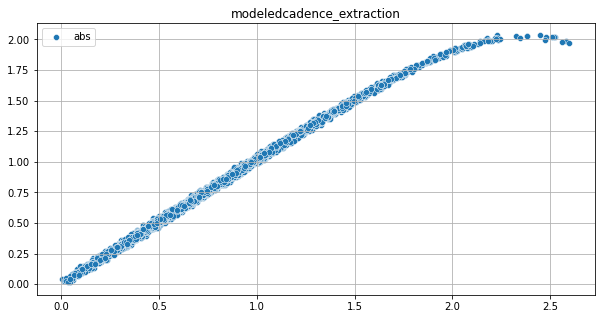

*** BEST ***
Shape:10 M:3 HL:5 nmse:-50.55971622467041 time:30.6758029460907
Validação - nmse:-41.40448570251465
Model: "model_wrapper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Parte_Real (Functional)     (None, 1)                 61        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Model: "model_wrapper_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Parte_Imaginaria (Functiona  (None, 1)                61        
 l)                                                              
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_______________________________________________________

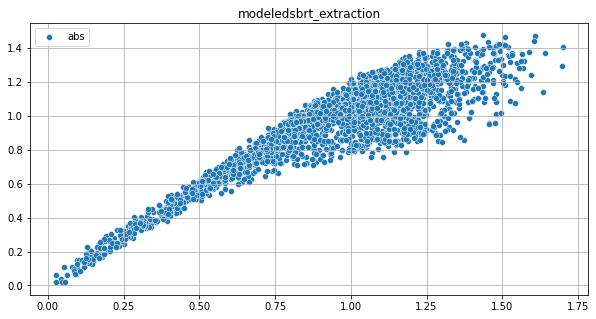

*** BEST ***
Shape:10 M:3 HL:5 nmse:-34.00686025619507 time:28.033026933670044
*** BEST ***
Shape:10 M:3 HL:6 nmse:-34.25981521606445 time:28.706437349319458
*** BEST ***
Shape:10 M:3 HL:7 nmse:-34.587485790252686 time:26.933148860931396
*** BEST ***
Shape:10 M:3 HL:9 nmse:-34.83565330505371 time:26.07894468307495
*** BEST ***
Shape:10 M:3 HL:10 nmse:-35.0646448135376 time:24.77439594268799
*** BEST ***
Shape:10 M:3 HL:12 nmse:-35.16914129257202 time:25.696868896484375
*** BEST ***
Shape:10 M:3 HL:16 nmse:-35.29541492462158 time:27.695936679840088


KeyboardInterrupt: 

In [10]:
for p in Path().glob('../data/*_extraction.csv'):
    data = load_csv2numpy(p)
 
    x = data[:, 0] + 1j*data[:, 1]
    x = normalize_data(x)
    x_abs = np.abs(x)

    y = data[:, 2] + 1j*data[:, 3]
    y = normalize_data(y)
    y_abs = np.abs(y)

    plt.figure(figsize=(10,5))
    sns.scatterplot(x=x_abs, y=y_abs, label='abs')
    plt.grid()
    plt.title(p.stem)
    plt.show()
    plt.close()

    best_model, M = find_best_M_HL(x, y, M_min=3, M_max=20, HL_min=5, HL_max=20)
    
    pv = p.parent/p.parts[-1].replace('extraction', 'validation')
    data = load_csv2numpy(pv)

    x = data[:, 0] + 1j*data[:, 1]
    x = normalize_data(x)
    y = data[:, 2] + 1j*data[:, 3]
    y = normalize_data(y)

    nmse = validation(best_model, x, y, M)

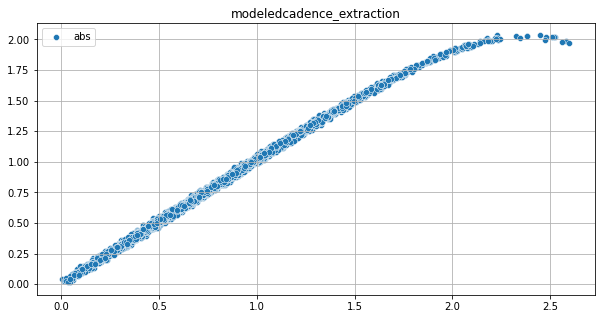

*** BEST ***
Shape:10 M:3 HL:5 nmse:-50.55971622467041 time:30.6758029460907
Validação - nmse:-41.40448570251465
Model: "model_wrapper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Parte_Real (Functional)     (None, 1)                 61        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Model: "model_wrapper_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Parte_Imaginaria (Functiona  (None, 1)                61        
 l)                                                              
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_______________________________________________________

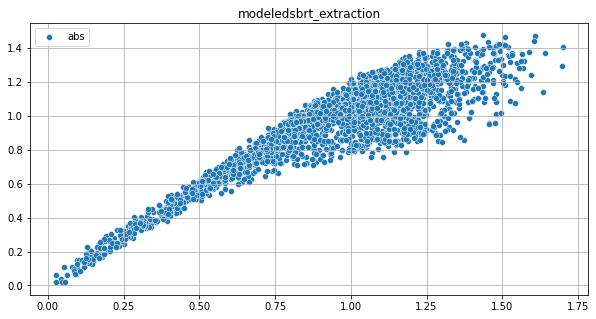

*** BEST ***
Shape:10 M:3 HL:5 nmse:-34.00686025619507 time:28.033026933670044
*** BEST ***
Shape:10 M:3 HL:6 nmse:-34.25981521606445 time:28.706437349319458
*** BEST ***
Shape:10 M:3 HL:7 nmse:-34.587485790252686 time:26.933148860931396
*** BEST ***
Shape:10 M:3 HL:9 nmse:-34.83565330505371 time:26.07894468307495
*** BEST ***
Shape:10 M:3 HL:10 nmse:-35.0646448135376 time:24.77439594268799
*** BEST ***
Shape:10 M:3 HL:12 nmse:-35.16914129257202 time:25.696868896484375
*** BEST ***
Shape:10 M:3 HL:16 nmse:-35.29541492462158 time:27.695936679840088


In [ ]:
# Problema inverso
for p in Path().glob('../data/*_extraction.csv'):
    data = load_csv2numpy(p)
 
    x = data[:, 2] + 1j*data[:, 3]
    x = normalize_data(x)
    x_abs = np.abs(x)

    y = data[:, 0] + 1j*data[:, 1]
    y = normalize_data(y)
    y_abs = np.abs(y)

    plt.figure(figsize=(10,5))
    sns.scatterplot(x=x_abs, y=y_abs, label='abs')
    plt.grid()
    plt.title(p.stem)
    plt.show()
    plt.close()

    best_model, M = find_best_M_HL(x, y, M_min=3, M_max=20, HL_min=5, HL_max=20)
    
    pv = p.parent/p.parts[-1].replace('extraction', 'validation')
    data = load_csv2numpy(pv)

    x = data[:, 2] + 1j*data[:, 3]
    x = normalize_data(x)

    y = data[:, 0] + 1j*data[:, 1]
    y = normalize_data(y)

    nmse = validation(best_model, x, y, M)